### Deformable Registration

In [1]:
import os

import numpy as np
import SimpleITK as sitk 
import matplotlib.pyplot as plt
import valis
from valis import registration

In [2]:
# source_dir = "/data/ANHIR_Out_Aff_1024_Masks_TRANSFORMED/"
source_dir = "/data/ANHIR_Out_Aff_1024_Masks_TRANSFORMED_DEFORMABLE_FIELD"
sample_id = "0"
sample_path = os.path.join(source_dir, sample_id)
source_path = os.path.join(sample_path, "source.mha")
target_path = os.path.join(sample_path, "transformed_target.mha")
target_mask_path = os.path.join(sample_path, "transformed_target_mask.mha")
source_mask_path = os.path.join(sample_path, "source_mask.mha")
deformation_field_path = os.path.join(sample_path, "transform_matrix.npy")

In [3]:
# Reading images
source = sitk.GetArrayFromImage(sitk.ReadImage(source_path)).astype(np.float32)
target = sitk.GetArrayFromImage(sitk.ReadImage(target_path)).astype(np.float32)
source_mask = sitk.GetArrayFromImage(sitk.ReadImage(source_mask_path)).astype(np.float32)
target_mask = sitk.GetArrayFromImage(sitk.ReadImage(target_mask_path)).astype(np.float32)
deformation_field = np.load(deformation_field_path)

In [4]:
deformation_field.shape

(1024, 659, 2)

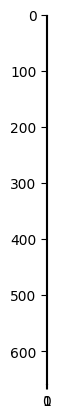

In [6]:
# visualize transformation matrix (deformation field) over the source image
plt.figure(figsize=(10,10))
plt.imshow(source[0], cmap='gray')
plt.imshow(deformation_field[0,0], cmap='jet', alpha=0.5)
plt.show()

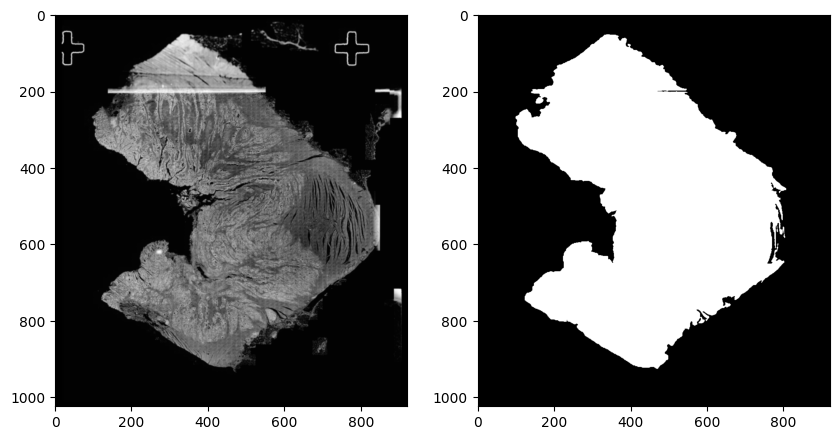

In [11]:
# show image and mask
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(source, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(source_mask, cmap="gray")
plt.show()

In [ ]:
def register(source, target, source_mask, target_mask, device="cuda"):
    # Load to CPU
    source = source.cpu().numpy()
    target = target.cpu().numpy()
    source_mask = source_mask.cpu().numpy()
    target_mask = target_mask.cpu().numpy()

    # Inverting intensity values
    target = 255 - target
    source = 255 - source

    # Background Removal
    target_mask = np.array(target_mask != 0, dtype=np.uint8)
    source_mask = np.array(source_mask != 0, dtype=np.uint8)
    target = cv2.bitwise_and(target, target, mask=target_mask)
    source = cv2.bitwise_and(source, source, mask=source_mask)

    # check_image_values(source)
    # check_image_values(target)

    # Getting SimpleITK Images from numpy arrays
    source_image_inv_sitk = sitk.GetImageFromArray(source)
    target_image_inv_sitk = sitk.GetImageFromArray(target)

    # Explicitly set the spacing to a non-zero value
    source_image_inv_sitk.SetSpacing([1.0, 1.0])
    target_image_inv_sitk.SetSpacing([1.0, 1.0])

    # Ensure the images have the same size and spacing
    resampler = sitk.ResampleImageFilter()
    resampler.SetSize(source_image_inv_sitk.GetSize())
    resampler.SetOutputSpacing(source_image_inv_sitk.GetSpacing())
    target_image_inv_sitk = resampler.Execute(target_image_inv_sitk)

    source_image_inv_sitk = sitk.Cast(source_image_inv_sitk, sitk.sitkFloat32)
    target_image_inv_sitk = sitk.Cast(target_image_inv_sitk, sitk.sitkFloat32)

    if (
        min(source_image_inv_sitk.GetSize()) < 2
        or min(target_image_inv_sitk.GetSize()) < 2
    ):
        raise ValueError("Images have degenerate dimensions.")

    # Define the transform
    transformDomainMeshSize = [4] * source_image_inv_sitk.GetDimension()
    tx = sitk.BSplineTransformInitializer(
        source_image_inv_sitk, transformDomainMeshSize
    )

    R = sitk.ImageRegistrationMethod()
    R.SetInitialTransformAsBSpline(tx, inPlace=True, scaleFactors=[1, 2, 5])
    R.SetMetricAsMattesMutualInformation(50)
    R.SetMetricSamplingStrategy(R.RANDOM)
    R.SetMetricSamplingPercentage(0.2)

    R.SetShrinkFactorsPerLevel([4, 2, 1])
    R.SetSmoothingSigmasPerLevel([4, 2, 1])
    R.SetOptimizerAsGradientDescentLineSearch(
        0.5, 100, convergenceMinimumValue=1e-4, convergenceWindowSize=5
    )
    R.SetInterpolator(sitk.sitkLinear)

    outTx = R.Execute(source_image_inv_sitk, target_image_inv_sitk)
    displacement_field_image = sitk.TransformToDisplacementField(
        outTx,
        sitk.sitkVectorFloat64,
        source_image_inv_sitk.GetSize(),
        source_image_inv_sitk.GetOrigin(),
        source_image_inv_sitk.GetSpacing(),
        source_image_inv_sitk.GetDirection(),
    )
    # Convert the displacement field image to a numpy array
    displacement_field_array = sitk.GetArrayFromImage(displacement_field_image)

    # Convert the numpy array to a PyTorch tensor and move to GPU
    return torch.from_numpy(displacement_field_array).to(device)


None
